In [76]:
import tensorflow as tensorflow 
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
print(tensorflow.__version__)

2.6.2


In [77]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 10
dataset = tensorflow.keras.preprocessing.image_dataset_from_directory(
"dataset",
seed = 123,
shuffle = True,
image_size = (IMAGE_SIZE,IMAGE_SIZE),
batch_size = BATCH_SIZE
)

Found 785 files belonging to 2 classes.


In [78]:
class_names = dataset.class_names
class_names

['Infected', 'Uninfected']

len(dataset) 25


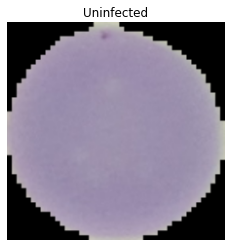

In [79]:
print("len(dataset)", len(dataset))
for image_batch, label_batch in  dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[label_batch[0]])
    plt.axis("off")

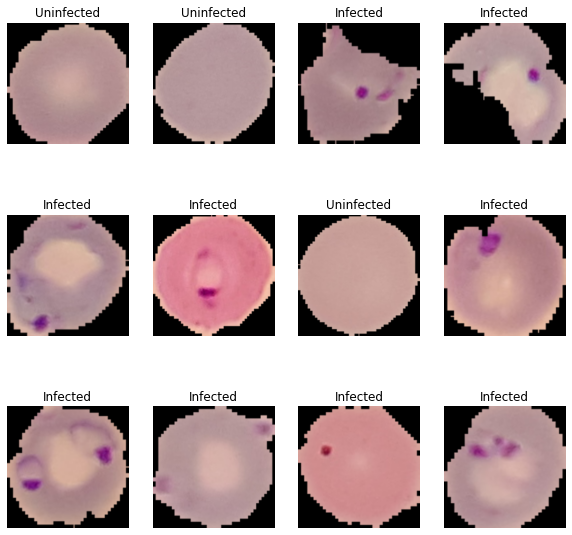

In [80]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [81]:
print("len(dataset) = ", len(dataset))
train_size = 0.8
print("len(dataset)*train_size = ", len(dataset)*train_size)
train_ds = dataset.take(14)
print("len(train_ds) = ", len(train_ds))
test_ds = dataset.skip(14)
print("len(test_ds) = ", len(test_ds))
val_size = 0.1
print("len(dataset)*val_size = ", len(dataset)*val_size)

len(dataset) =  25
len(dataset)*train_size =  20.0
len(train_ds) =  14
len(test_ds) =  11
len(dataset)*val_size =  2.5


In [82]:
val_ds = test_ds.take(14)
print("len(val_ds) = ", len(val_ds))
test_ds = test_ds.skip(14)
print("len(test_ds) = ", len(test_ds))

len(val_ds) =  11
len(test_ds) =  0


In [83]:
def get_dataset_partitions_tensorflow(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [84]:
train_ds, val_ds, test_ds = get_dataset_partitions_tensorflow(dataset)
print("len(train_ds) = ", len(train_ds))
print("len(val_ds) = ", len(val_ds))
print("len(test_ds) = ", len(test_ds))

len(train_ds) =  20
len(val_ds) =  2
len(test_ds) =  3


In [85]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tensorflow.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tensorflow.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tensorflow.data.AUTOTUNE)

In [86]:
resize_and_rescale = tensorflow.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [87]:
data_augmentation = tensorflow.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [88]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tensorflow.data.AUTOTUNE)

In [89]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [90]:
model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_20 (Sequential)   (32, 224, 224, 3)         0         
_________________________________________________________________
conv2d_48 (Conv2D)           (32, 222, 222, 32)        896       
_________________________________________________________________
max_pooling2d_48 (MaxPooling (32, 111, 111, 32)        0         
_________________________________________________________________
conv2d_49 (Conv2D)           (32, 109, 109, 64)        18496     
_________________________________________________________________
max_pooling2d_49 (MaxPooling (32, 54, 54, 64)          0         
_________________________________________________________________
conv2d_50 (Conv2D)           (32, 52, 52, 64)          36928     
_________________________________________________________________
max_pooling2d_50 (MaxPooling (32, 26, 26, 64)        

In [91]:
model.compile(
    optimizer='adam',
    loss=tensorflow.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)
scores = model.evaluate(test_ds)

Epoch 1/50
20/20 [==============================] - 43s 2s/step - loss: 0.7882 - accuracy: 0.4576 - val_loss: 0.7070 - val_accuracy: 0.4375
Epoch 2/50
11/20 [===============>..............] - ETA: 20s - loss: 0.6961 - accuracy: 0.5312

In [50]:
print("Scores = ", scores)
print("history = ", history)
print("history.params = ", history.params)
print("history.history.keys() = ", history.history.keys())
print("type(history.history['loss']) = ", type(history.history['loss']))
print("len(history.history['loss']) = ", len(history.history['loss']))
print("len(history.history['loss']) = ", len(history.history['loss']))

Scores =  [0.19474752247333527, 0.9365079402923584]
history =  <keras.callbacks.History object at 0x000001E59410A470>
history.params =  {'verbose': 1, 'epochs': 20, 'steps': 16}
history.history.keys() =  dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
type(history.history['loss']) =  <class 'list'>
len(history.history['loss']) =  20
len(history.history['loss']) =  20


In [51]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

ValueError: x and y must have same first dimension, but have shapes (10,) and (20,)

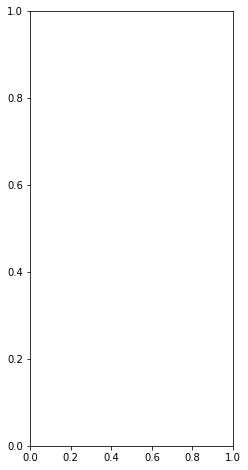

In [52]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Uninfected
predicted label: Uninfected


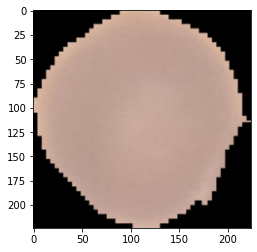

In [53]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [54]:
def predict(model, img):
    img_array = tensorflow.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tensorflow.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

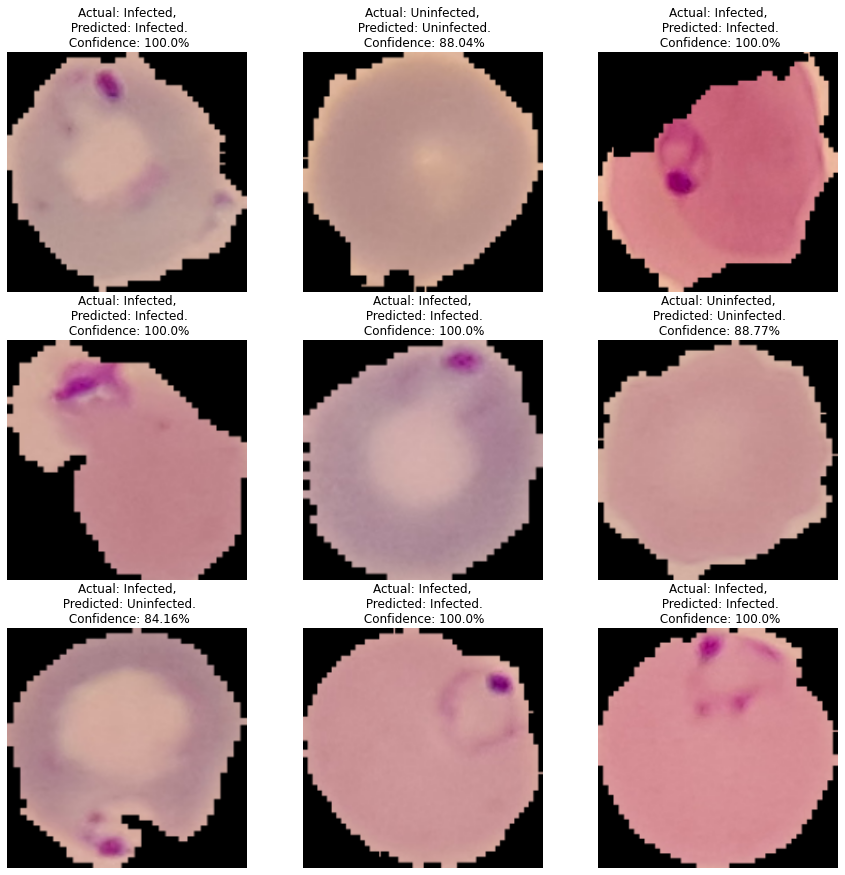

In [55]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")